In [355]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from scipy import special
import sympy

params = {
    'figure.figsize': (8.5, 6.5),
    'font.style': 'normal',
    'axes.labelsize': 25,
    'font.size': 16,
    'legend.fontsize': 11,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 8,
    'ytick.major.size': 10,
    'xtick.minor.size': 4,
    'ytick.minor.size': 4,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'font.family': 'serif',
    'legend.framealpha': 1,  # Set legend alpha to 1
    'legend.borderpad': 0.2,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True
}
plt.rcParams.update(params)

from BesselML import Problem
from BesselML import Solution
from BesselML import Promising_solution
sympy.init_printing()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---------------------------------- Hypergeometrical functions ----------------------------------

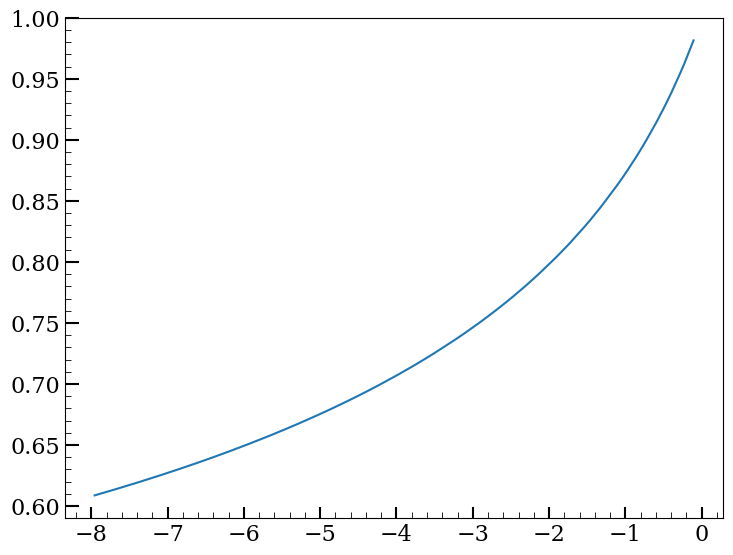

In [2]:
np.random.seed(42) #Keeping the seed for reproducibility


x_prime_dstrn_train = np.sort(np.random.uniform(-8.0, -0.0016, 200)) 
# Training data from uniform distribution
x_prime_dstrn_test = np.sort(np.random.uniform(-8.0, -0.0016, 200))

target_train = special.hyp2f1(1/3, 1, 11/6, x_prime_dstrn_train)
target_test = special.hyp2f1(1/3, 1, 11/6, x_prime_dstrn_test)

plt.plot(x_prime_dstrn_train, target_train)

#hypergeom function defined only for x < 0, the limiting values are 1 and 0 (later on we try to achieve these)

In [ ]:
# Define problem for SR optimization, PyOperon works best with RMSE.
# The main constraining parameter is time (in sec), so the other
# parameters are set to very high values, so that the optimization
# is not limited by them.
# The maximum length of the expression is set to 50, which is a common value

hypergeom_args = {
    'allowed_symbols': "add,sub,mul,aq,constant,variable",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'],
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*3,
    'n_threads': 12,
}

Problem_hypergeom = Problem("Hypergeometric Function Problem", (x_prime_dstrn_train, target_train), (x_prime_dstrn_test, target_test), hypergeom_args)

In [88]:
# Solve the problem using PyOperon

Problem_hypergeom.solve()
print(f"number of solutions: {len(Problem_hypergeom.solutions)}")

[0.02626180462539196, 5.0], 194.46, (0.900047898293 + ((-0.093972869217) * ((-0.441155433655) * X1))), 0.00
[0.006139083299785852, 7.0], 204.50, (0.966356098652 + (0.020117025822 * ((4.397469520569 * X1) / (sqrt(1 + (0.220865413547 * X1) ^ 2))))), 0.00
[0.0018482841551303864, 9.0], 205.56, (0.426210731268 + (7.007121562958 * (0.434294492006 / (sqrt(1 + (5.315444946289 - (1.389047145844 * X1)) ^ 2))))), 0.00
[0.0002591857628431171, 11.0], 209.50, (0.409980177879 + ((-1.394863367081) * ((-1.027533888817) / (sqrt(1 + ((2.225421667099 / (sqrt(1 + (0.210300207138 * X1) ^ 2))) + ((-0.754062056541) * X1)) ^ 2))))), 0.00
[0.0002165615005651489, 13.0], 215.25, (0.461622148752 + (0.388028055429 * ((3.483138322830 + (0.075968220830 * X1)) / (sqrt(1 + ((2.312786102295 / (sqrt(1 + ((-0.226687043905) * X1) ^ 2))) + ((-0.802885055542) * X1)) ^ 2))))), 0.00
[0.000216542583075352, 15.0], 228.10, ((-5.874247074127) + (0.385421186686 * (16.439052581787 + ((3.506095886230 + (0.076625406742 * X1)) / (sqrt(

<Axes: title={'center': 'Hypergeometric Function Problem: solution 3 Train'}>

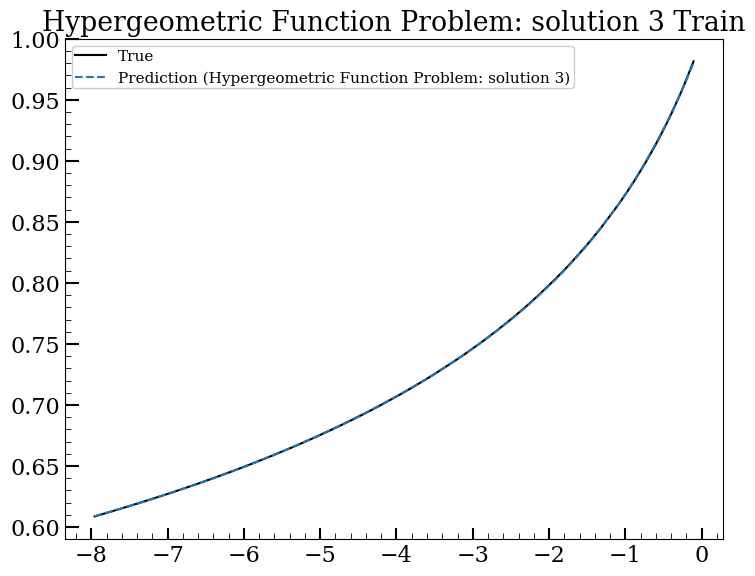

In [89]:
# Display and iterate through the solutions

Problem_hypergeom.solutions[3].plot_results()

<Axes: xlabel='$-x$', ylabel='Fractional Error'>

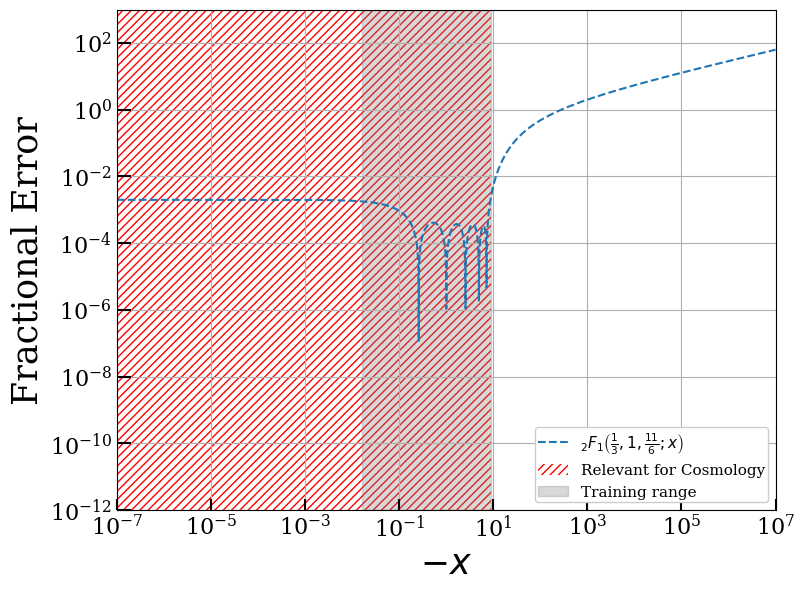

In [199]:
# Defining the metric that we want look at,
# in this case it is the fractional error of the hypergeometric function

coeff = [1/3, 1, 11/6]  
# Coefficients for the hypergeometric function for the growth factor
x_val = -1.0 * np.geomspace(10**(-7),10**7, 10000)
# Geomspace, so on the logarithmic scale we have equal spacing
Problem_hypergeom.solutions[5].plot_fractional_error_hypergeom(x_val, coeff)


#plt.savefig("/home/danielct/Pictures/oxford_internship/fractional_error_growth_factor_5min_run_sol_5.pdf", dpi=300, bbox_inches='tight')

<Axes: title={'center': 'Hypergeometric Function Problem - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

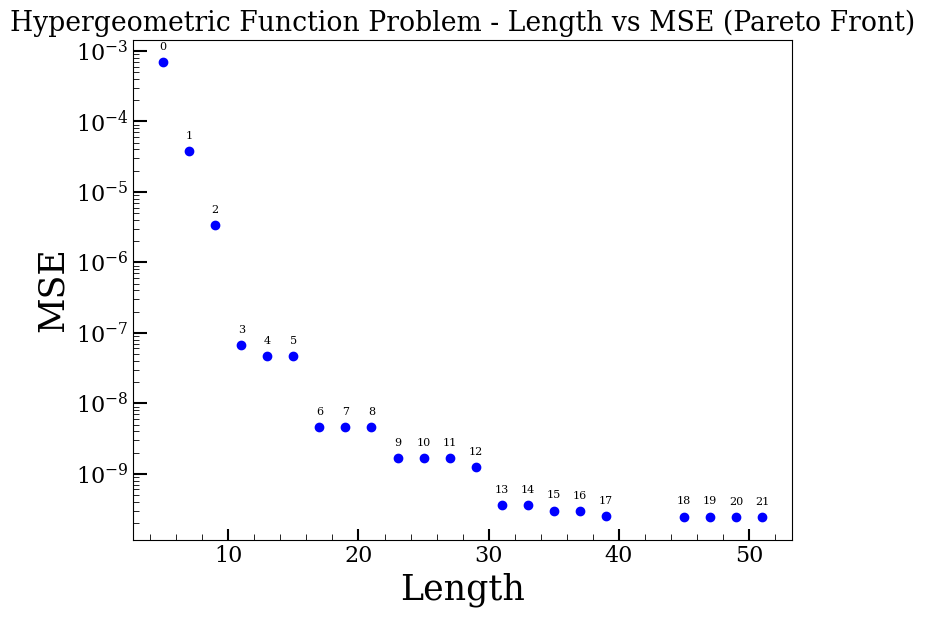

In [200]:
# Pareto front for the solutions

Problem_hypergeom.plot_l_vs_mse()

In [323]:
# Saving the solutions to LaTeX format for later use

Problem_hypergeom.export_solutions_to_latex(n=20)

LaTeX file written to latex_files/Hypergeometric_Function_Problemno_solutions_20/solutions.tex


In [333]:
# Iterating and displaying the solutions

k=3
Problem_hypergeom.solutions[k].display_expression()
b_vals = Problem_hypergeom.solutions[k].extract_and_format()[1]
b_vals

<IPython.core.display.Math object>

{'b0': 0.40998017787899244,
 'b1': 1.433269379945159,
 'b2': 0.5686095851148139,
 'b3': 3.3562120779270117,
 'b4': 0.04422617712228316,
 'b5': 4.952501596393631}

In [358]:
# Computing the limits of our approximation
# Once again, the limiting values are 1 (for x --> 0) and 0 (x --> -inf)

Problem_hypergeom.solutions[k].compute_limits(0).evalf(), Problem_hypergeom.solutions[k].compute_limits(-np.inf).evalf()

In [379]:
# Defining class that will for now be storing expressions for another 
# analysis and reoptimization of the solution

from BesselML import Promising_solution
Promising_solution_0_limits = Promising_solution(Problem_hypergeom.solutions[k].sympy_expr, (x_prime_dstrn_train, target_train), Problem_hypergeom.solutions[k], b_vals)

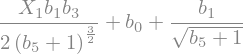

In [380]:
# Computing expansion at x = 0 up to two order terms (n=2)
# This part is crucial, as for some solutions (pow, log)  quite often the 
# expansion cannot be computed. 

expansion = Promising_solution_0_limits.compute_expansion_at_val(0, n=2)
expansion

In [381]:
# Automatically generating constraints from the expansion,
# so that the absolute and linear terms correspond to those
# computed analytically for this hypergeometric function

constraints, const_term, linear_term = Promising_solution_0_limits.generate_constraints_from_expansion()

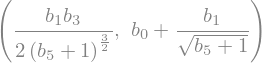

In [382]:
linear_term, const_term

In [383]:
# Reoptimising with the constraints defined above

Promising_solution_0_limits.optimisation(constraints_eq=constraints)

/home/danielct/Desktop/Internship_Oxford_2025/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 1289, function evaluations: 12131, CG iterations: 3708, optimality: 4.53e-08, constraint violation: 2.78e-17, execution time: 3e+01 s.

Optimization summary:
Parameter | Old Value | New Value | Abs Difference
--------- | --------- | --------- | --------------
b0        | 0.40998   | 0.430685  | 0.0207051     
b1        | 1.43327   | 1.39288   | 0.0403875     
b2        | 0.56861   | 0.732686  | 0.164077      
b3        | 3.35621   | 3.8233    | 0.46709       
b4        | 0.0442262 | 0.0744089 | 0.0301827     
b5        | 4.9525    | 4.98582   | 0.0333194     



(0.43068526462949 + 1.39288187246622/sqrt(0.732686424902179*X1**2 - 3.82330200798659*X1/sqrt(0.0744089211010631*X1**2 + 1) + 1 + 4.98582097002567/(0.0744089211010631*X1**2 + 1)),
 {'b0': np.float64(0.4306852646294897),
  'b1': np.float64(1.3928818724662229),
  'b2': np.float64(0.7326864249021785),
  'b3': np.float64(3.823302007986587),
  'b4': np.float64(0.07440892110106312),
  'b5': np.float64(4.985820970025667)},
 {'b0': np.float64(0.02070508675049726),
  'b1': np.float64(0.04038750747893616),
  'b2': np.float64(0.16407683978736465),
  'b3': np.float64(0.4670899300595752),
  'b4': np.float64(0.030182743978779958),
  'b5': np.float64(0.033319373632036076)})

<Axes: xlabel='$-x$', ylabel='Fractional Error'>

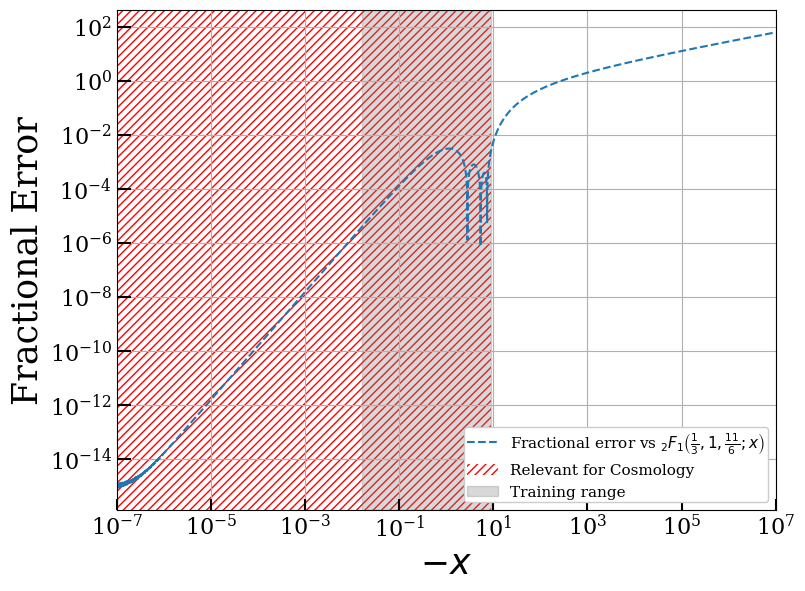

In [384]:
Promising_solution_0_limits.plot_fractional_error_hypergeom(x_val, coeff)

In [385]:
import sympy as sp
str(Promising_solution_0_limits.sympy_expr)
#Promising_solution_0_limits.sympy_expr

'b0 + b1/sqrt(X1**2*b2 - X1*b3/sqrt(X1**2*b4 + 1) + b5/(X1**2*b4 + 1) + 1)'

In [386]:
# Modification for the upper limit is not implemented automatically,
# (very hard), so we have to do it manually.

manual = 'b1 / (X1**2*b2 - (X1*b3 / sqrt(X1**2*b4 + 1)) + (b5 / (X1**2*b4 + 1)) + 1)**(1/6)'


#manual = str(Promising_solution_0_limits.sympy_expr)


# Another computation of the expansion, so that new constraint and parameters
# are updated

from BesselML import Promising_solution
#Manual_limiting_test = Promising_solution(sp.parsing.sympy_parser.parse_expr(manual),  (x_prime_dstrn_train, target_train), Promising_solution_0_limits.modified_parameters)
Manual_limiting_test = Promising_solution(sp.parsing.sympy_parser.parse_expr(manual),  (x_prime_dstrn_train, target_train), Promising_solution_0_limits.original_solution,Promising_solution_0_limits.modified_parameters)
constraints_man, const_term_man, linear_term_man = Manual_limiting_test.generate_constraints_from_expansion()

In [387]:
# We can create dummy initialisation parameters, 
# if those modified produce suboptimal results

initial_params_second_opt = {
    'b0' : 0.0,
    'b1': 1.0,
    'b2': 1.0,
    'b3': 0.1,  # Start smaller for nested terms
    'b4': 1.0,
    'b5': 0.1,
}
Manual_limiting_test.optimisation(constraints_eq=constraints_man)

/home/danielct/Desktop/Internship_Oxford_2025/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 58, function evaluations: 490, CG iterations: 85, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time:  1.5 s.

Optimization summary:
Parameter | Old Value | New Value  | Abs Difference
--------- | --------- | ---------  | --------------
b0        | 0.430685  | 0.430685   | 1.66533e-16   
b1        | 1.39288   | 1.30369    | 0.0891944     
b2        | 0.732686  | 0.907884   | 0.175197      
b3        | 3.8233    | 5.35586    | 1.53256       
b4        | 0.0744089 | 0.00699385 | 0.0674151     
b5        | 4.98582   | 3.90954    | 1.07628       



(1.30368751876208/(0.907883649068381*X1**2 - 5.35586482045016*X1/sqrt(0.00699384870351791*X1**2 + 1) + 1 + 3.90954275207931/(0.00699384870351791*X1**2 + 1))**(1/6),
 {'b0': np.float64(0.43068526462948953),
  'b1': np.float64(1.3036875187620764),
  'b2': np.float64(0.9078836490683815),
  'b3': np.float64(5.355864820450162),
  'b4': np.float64(0.006993848703517913),
  'b5': np.float64(3.9095427520793145)},
 {'b0': np.float64(1.6653345369377348e-16),
  'b1': np.float64(0.08919435370414641),
  'b2': np.float64(0.17519722416620298),
  'b3': np.float64(1.5325628124635755),
  'b4': np.float64(0.06741507239754521),
  'b5': np.float64(1.0762782179463528)})

<Axes: xlabel='$-x$', ylabel='Fractional Error'>

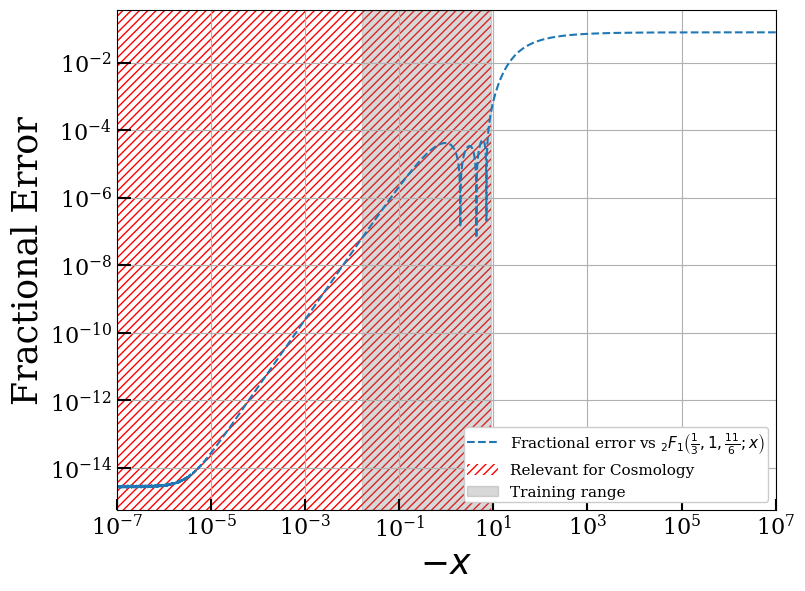

In [388]:
Manual_limiting_test.plot_fractional_error_hypergeom(x_val, coeff)

----------- Multidimensional optimisation ----------------

In [ ]:
# Latin Hypercube Sampling Example for comoving distance (flat universe, negligible radiation), optimising based w.t.s. to redshift and omega_matter
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=200)

l_bound = [0, 0.1]
u_bound = [3, 0.5]

sample = qmc.scale(sample, l_bound, u_bound)
sample

In [ ]:
# Generating training data for comoving distance


from scipy.integrate import quad
from typing import Tuple


def comoving_distance(params: Tuple[float, float]) -> float:

    z, omega_m = params
    if z < 0 or not (0 < omega_m < 1):
        raise ValueError("Invalid input: z must be >= 0 and 0 < omega_m < 1")

    def inv_E(z_prime):
        return 1.0 / np.sqrt(omega_m * (1 + z_prime)**3 + (1 - omega_m))

    integral, _ = quad(inv_E, 0, z)
    D_C =  integral  # in Mpc
    return D_C

comoving_distances = np.array([comoving_distance(sample[i]) for i in range(len(sample))])

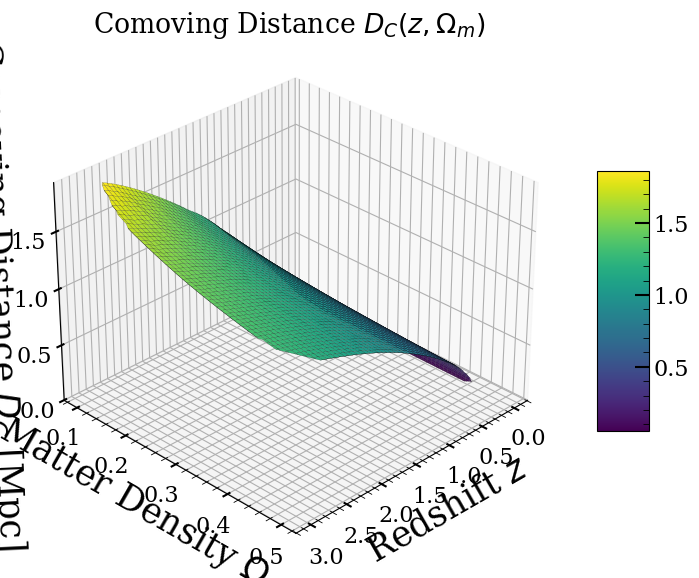

In [ ]:
# Plotting the comoving distance as a function of redshift and matter density
# Just for visualize intuition

from scipy.interpolate import griddata

# Create grid
z_lin = np.linspace(sample[:, 0].min(), sample[:, 0].max(), 100)
omega_m_lin = np.linspace(sample[:, 1].min(), sample[:, 1].max(), 100)
Z_grid, OmegaM_grid = np.meshgrid(z_lin, omega_m_lin)

# Interpolate the scattered data onto the grid
D_C_grid = griddata(sample, comoving_distances, (Z_grid, OmegaM_grid), method='cubic')

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Z_grid, OmegaM_grid, D_C_grid,
                       cmap='viridis', edgecolor='k', linewidth=0.1)

ax.set_xlabel('Redshift $z$')
ax.set_ylabel('Matter Density $\\Omega_m$')
ax.set_zlabel('Comoving Distance $D_C$ [Mpc]')
ax.set_title('Comoving Distance $D_C(z, \\Omega_m)$')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


In [ ]:
# Problem problem initalisation

name = "comoving distance 2d problem"

d2_args = {
    'allowed_symbols': "add,sub,mul,pow,aq,constant,log,exp,variable",
    'epsilon': 1e-5,
    'objectives': ['mse', 'length'],
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*5,
    'n_threads': 12,
}

Problem_comoving_distance = Problem(name, (sample, comoving_distances), (sample, comoving_distances), d2_args)

In [15]:
Problem_comoving_distance.solve()

Training data has multiple dimensions, fitting directly.
[0.017210014164447784, 5.0], 198.64, (0.184921100736 + ((-0.498270690441) * ((-1.036184310913) * X1))), 0.02
[0.013819927349686623, 6.0], 205.36, (2.476457595825 + ((-2.439133882523) * exp(((-0.346306473017) * X1)))), 0.01
[0.0014438630314543843, 7.0], 211.43, (2.287428617477 + ((-2.231162309647) * ((0.287036806345 * X2) ^ (0.150959908962 * X1)))), 0.00
[0.0013097182381898165, 8.0], 216.37, (3.950957775116 + ((-1.436923861504) * exp(((0.290108084679 * X2) ^ (0.090986534953 * X1))))), 0.00
[0.0009672812884673476, 9.0], 220.38, (2.181011915207 + ((-2.229234933853) * (((0.485346198082 * X2) ^ (0.208051398396 * X1)) / (sqrt(1 + (0.900992333889 * X2) ^ 2))))), 0.00
[7.332584937103093e-05, 10.0], 219.85, (0.986938476562 + ((-1.001623153687) * (exp(((-0.897887527943) * X1)) + (((-0.416065424681) * X1) / (sqrt(1 + (6.526662826538 * X2) ^ 2)))))), 0.00
[6.640525680268183e-05, 11.0], 224.31, (0.010433965363 + ((-0.646047830582) * ((((-1.06

In [16]:
n=2
Problem_comoving_distance.solutions[n].extract_and_format(), Problem_comoving_distance.solutions[n].display_expression() 

<IPython.core.display.Math object>

(('- X_{2}^{X_{1}·b_{2}}·b_{0}·b_{1}^{X_{1}·b_{2}} + b_{3}',
  {'b0': 2.231162309647061,
   'b1': 0.28703680634498596,
   'b2': 0.15095990896199396,
   'b3': 2.2874286174769622},
  -X2**(X1*b2)*b0*b1**(X1*b2) + b3),
 None)

<Axes: title={'center': 'comoving distance 2d problem - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

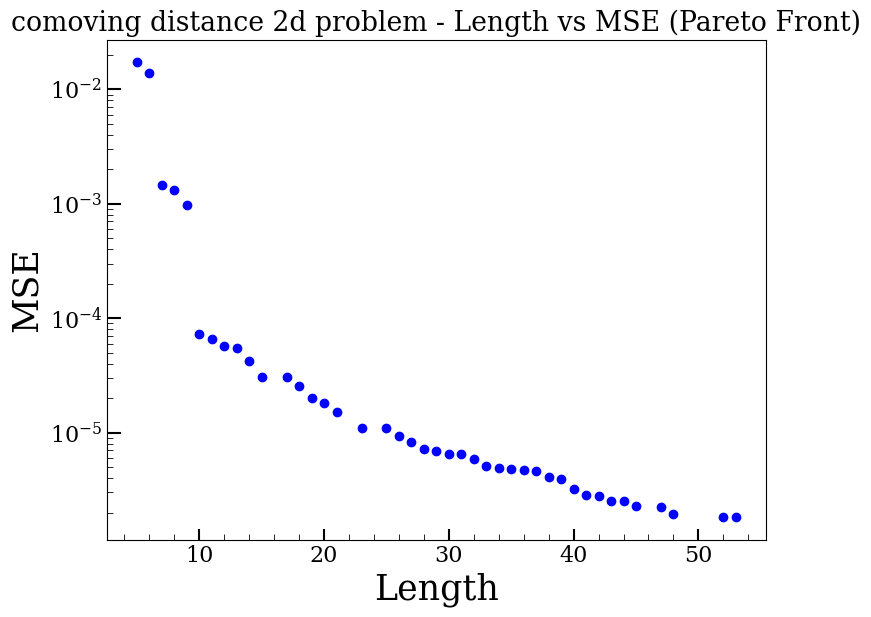

In [ ]:
# Pareto front for the solutions

Problem_comoving_distance.plot_l_vs_mse()